**SPRAWOZDANIE**

Programowanie Równoległe i Rozproszone

Laboratorium nr 8

**Autor**: Fabrycki Łukasz 82623 o kurcze 

________________________________________________________________________________
**Zbiór Julii** - zbiór punktów w przestrzeni kompleksowej, który został zdefiniowany przez francuskiego matematyka Gastona Julia w 1918 roku. Jest on używany w teorii liczb kompleksowych i jest szczególnie ważny w dziedzinie fraktali.

Aby zdefiniować zbiór Julii, należy wybrać jakąś stałą liczbę kompleksową c i zdefiniować zbiór w następujący sposób: jeśli z jest liczbą kompleksową, to z należy do zbioru Julii, jeśli i tylko wtedy, gdy iteracja zastępująca z = z^2 + c po wielokrotnym jej wykonaniu prowadzi do punktu, który jest blisko zera. Innymi słowy, jeśli po wielokrotnym wykonaniu iteracji z = z^2 + c wartość z nie ulega znaczącemu zmianie, to z należy do zbioru Julii.

Zbiór Julii jest zbiorem fraktalnym, co oznacza, że ma on nieregularną strukturę geometryczną, która jest podobna na wszystkich skalach. Może on mieć różne kształty, w zależności od wybranej stałej c, a jego wygląd jest często używany do tworzenia atrakcyjnych obrazów w grafice komputerowej.

________________________________________________________________________________

**Zbiór Mandelbrota** - fraktal, który został opisany przez Benoît Mandelbrot w 1980 roku. Jest to zbiór punktów w przestrzeni kompleksowej, który jest zdefiniowany przez iterację zastępującą z = z^2 + c, gdzie z i c są liczbami kompleksowymi.

Aby sprawdzić, czy dany punkt z należy do zbioru Mandelbrota, należy wielokrotnie wykonywać iterację z = z^2 + c, zaczynając od z = 0 i sprawdzając, czy wartość z nie rośnie zbyt szybko. Jeśli po wielokrotnym wykonaniu iteracji wartość z nie ulega znaczącemu wzrostowi, to punkt c należy do zbioru Mandelbrota. W przeciwnym razie punkt c nie należy do zbioru Mandelbrota.

Zbiór Mandelbrota jest fraktalem, co oznacza, że ma on nieregularną strukturę geometryczną, która jest podobna na wszystkich skalach. Może on przybierać różne kształty i jest często używany do tworzenia atrakcyjnych obrazów w grafice komputerowej.
________________________________________________________________________________

**CUDA** - technologia opracowana przez firmę NVIDIA, która umożliwia programistom wykorzystanie mocy obliczeniowej kart graficznych (GPU) do obliczeń naukowych i innych zastosowań wymagających dużej mocy obliczeniowej.

CUDA to architektura programowania, która umożliwia programistom napisanie kodu, który jest uruchamiany na GPU zamiast na procesorze (CPU). Dzięki temu programiści mogą skorzystać z dużej mocy obliczeniowej GPU do wykonywania obliczeń równolegle, co pozwala na znaczne przyspieszenie wykonywania obliczeń.

CUDA jest szeroko stosowana w różnych dziedzinach, takich jak obliczenia naukowe, sztuczna inteligencja, symulacje fizyczne, rendering 3D i inne. Pozwala to programistom na tworzenie aplikacji, które mogą wykonywać obliczenia w dużym zakresie w sposób szybszy i bardziej wydajny niż przy użyciu procesora CPU.

________________________________________________________________________________

1. Julia CPU

In [ ]:
%%cu 
#include<stdio.h>
#define DIM 2000

struct cuComplex{
    float r;
    float i;
    cuComplex(float a, float b):r(a),i(b){}
    float magnitude2(void){return r*r+i*i;}
    cuComplex operator*(const cuComplex &a){ return cuComplex(r*a.r-i*a.i,i*a.r+r*a.i); }
    cuComplex operator+(const cuComplex &a){ return cuComplex(r+a.r,i+a.i); }
};
    int julia(int x, int y){
    const float scale=1.5;
    float jx=scale*(float)(DIM/2-x)/(DIM/2);
    float jy=scale*(float)(DIM/2-y)/(DIM/2);
    cuComplex c(-0.8,0.156);
    cuComplex a(jx,jy);
    int i=0;
    for(i=0;i<200;i++){
        a=a*a+c;
        if(a.magnitude2()>1000) return 0;
    }
    return 1;
}
    void kernel(unsigned char *ptr){
        for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            int juliaValue=julia(x,y);
            ptr[offset*4+0]=255*juliaValue;
            ptr[offset*4+1]=0;
            ptr[offset*4+2]=0;
            ptr[offset*4+3]=255;
          }
        }
    }
  
struct DataBlock{
    unsigned char *dev_bitmap;
};

void wypisz_RGB_fraktal(unsigned char *ptr){
    for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            printf("\n%d, %d, %d, %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2], ptr[offset*4+3]);
        }
    }
}
void save_to_file(unsigned char *ptr){
    FILE *fp=fopen("Fraktal_CPU.ppm","w");
    fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
     for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
}
fclose(fp);
}
int main(void){
    clock_t start, end;
    double execution_time;
    start = clock();
    DataBlock data;
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM*DIM*4;
    kernel(bitmap);
    save_to_file (bitmap);
    end = clock();
    execution_time = ((double)(end - start))/CLOCKS_PER_SEC;
    printf("Time taken to execute in seconds : %f", execution_time);
}


2. Julia GPU

In [ ]:
%%cu 
#include<stdio.h>
#define DIM 2000
struct cuComplex{
    float r;
    float i;
    __device__ cuComplex(float a, float b):r(a),i(b){}
    __device__ float magnitude2(void){ return r*r+i*i; }
    __device__ cuComplex operator*(const cuComplex &a){ return cuComplex(r*a.r-i*a.i,i*a.r+r*a.i); }
    __device__ cuComplex operator+(const cuComplex &a){ return cuComplex(r+a.r,i+a.i); }
};
__device__ int julia(int x, int y){
    const float scale=1.5;
    float jx=scale*(float)(DIM/2-x)/(DIM/2);
    float jy=scale*(float)(DIM/2-y)/(DIM/2);
    cuComplex c(-0.8,0.156);
    cuComplex a(jx,jy);
    int i=0;
    for(i=0;i<200;i++){
        a=a*a+c;
        if(a.magnitude2()>1000) return 0;
    }
    return 1;
}
__global__ void kernel(unsigned char *ptr){
    int x=blockIdx.x;
    int y=blockIdx.y;
    int offset=x+y*gridDim.x;

    int juliaValue=julia(x,y);
    ptr[offset*4+0]=255*juliaValue;
    ptr[offset*4+1]=0;
    ptr[offset*4+2]=0;
    ptr[offset*4+3]=255;
}
struct DataBlock{
    unsigned char *dev_bitmap;
};

void wypisz_RGB_fraktal(unsigned char *ptr){
    for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            printf("\n%d, %d, %d, %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2], ptr[offset*4+3]);
        }
    }
}
void save_to_file(unsigned char *ptr){
    FILE *fp=fopen("Fraktal_GPU.ppm","w");
    fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
     for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
}
fclose(fp);
}
int main(void){
    clock_t start, end;
    double execution_time;
    start = clock();
    DataBlock data;
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM*DIM*4;
    unsigned char *dev_bitmap;

    cudaMalloc((void**)&dev_bitmap, image_size);
    data.dev_bitmap=dev_bitmap;
    dim3 grid(DIM,DIM);
    kernel<<<grid,1>>>(dev_bitmap);
    cudaMemcpy(bitmap,dev_bitmap,image_size,cudaMemcpyDeviceToHost);
    cudaFree(dev_bitmap);
    save_to_file (bitmap);
    end = clock();
    execution_time = ((double)(end - start))/CLOCKS_PER_SEC;
    printf("Time taken to execute in seconds : %f", execution_time);
}


Porównanie

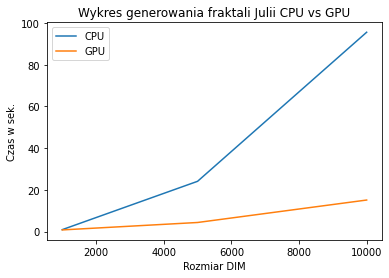

In [1]:
import matplotlib.pyplot as plt

dims = (1000, 5000, 10000)
timeCPU = (0.947622, 24.114844, 95.583010)
timeGPU = (0.811615, 4.371521, 15.140495)


plt.plot(dims, timeCPU, label='CPU')
plt.plot(dims, timeGPU, label='GPU')
plt.xlabel("Rozmiar DIM")
plt.ylabel("Czas w sek.")
plt.title("Wykres generowania fraktali Julii CPU vs GPU")
plt.legend()
plt.show()

3. Mandelbrot CPU

In [ ]:
%%cu 
#include<stdio.h>
#define DIM 6000

struct cuComplex{
    float r;
    float i;
    cuComplex(float a, float b):r(a),i(b){}
    float magnitude2(void){return r*r+i*i;}
    cuComplex operator*(const cuComplex &a){ return cuComplex(r*a.r-i*a.i,i*a.r+r*a.i); }
    cuComplex operator+(const cuComplex &a){ return cuComplex(r+a.r,i+a.i); }
};
    int mandelbrot(int x, int y){
    const float scale=1.5;
    float jx=scale*(float)(DIM/2-x)/(DIM/2);
    float jy=scale*(float)(DIM/2-y)/(DIM/2);
    cuComplex c(jx,jy);
    cuComplex a(0,0);
    int i=0;
    for(i=0;i<200;i++){
        a=a*a+c;
        if(a.magnitude2()>1000) return 0;
    }
    return 1;
}
    void kernel(unsigned char *ptr){
        for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            int mandelbrotValue=mandelbrot(x,y);
            ptr[offset*4+0]=255*mandelbrotValue;
            ptr[offset*4+1]=0;
            ptr[offset*4+2]=0;
            ptr[offset*4+3]=255;
          }
        }
    }
  
struct DataBlock{
    unsigned char *dev_bitmap;
};

void wypisz_RGB_fraktal(unsigned char *ptr){
    for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            printf("\n%d, %d, %d, %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2], ptr[offset*4+3]);
        }
    }
}
void save_to_file(unsigned char *ptr){
    FILE *fp=fopen("Fraktal_CPU.ppm","w");
    fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
     for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
}
fclose(fp);
}
int main(void){
    clock_t start, end;
    double execution_time;
    start = clock();
    DataBlock data;
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM*DIM*4;
    kernel(bitmap);
    save_to_file (bitmap);
    end = clock();
    execution_time = ((double)(end - start))/CLOCKS_PER_SEC;
    printf("Time taken to execute in seconds : %f", execution_time);
}


4. Mandelbrot GPU

In [ ]:
%%cu
#include<stdio.h>
#define DIM 6000
struct cuComplex{
    float r;
    float i;
    __device__ cuComplex(float a, float b):r(a),i(b){}
    __device__ float magnitude2(void){ return r*r+i*i; }
    __device__ cuComplex operator*(const cuComplex &a){ return cuComplex(r*a.r-i*a.i,i*a.r+r*a.i); }
    __device__ cuComplex operator+(const cuComplex &a){ return cuComplex(r+a.r,i+a.i); }
};
__device__  int mandelbrot(int x, int y){
    const float scale=1.5;
    float jx=scale*(float)(DIM/2-x)/(DIM/2);
    float jy=scale*(float)(DIM/2-y)/(DIM/2);
    cuComplex c(jx,jy);
    cuComplex a(0,0);
    int i=0;
    for(i=0;i<200;i++){
        a=a*a+c;
        if(a.magnitude2()>1000) return 0; 
    }
    return 1;
}
__global__ void kernel(unsigned char *ptr){
    int x=blockIdx.x;
    int y=blockIdx.y;
    int offset=x+y*gridDim.x;

    int mandelbrotValue=mandelbrot(x,y);
    ptr[offset*4+0]=255*mandelbrotValue;
    ptr[offset*4+1]=0;
    ptr[offset*4+2]=0;
    ptr[offset*4+3]=255;
}
struct DataBlock{
    unsigned char *dev_bitmap;
};

void wypisz_RGB_fraktal(unsigned char *ptr){
    for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            printf("\n%d, %d, %d, %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2], ptr[offset*4+3]);
        }
    }
}
void save_to_file(unsigned char *ptr){
    FILE *fp=fopen("Fraktal_GPU.ppm","w");
    fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
     for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++){
            int offset=x+y*DIM;
            fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1],ptr[offset*4+2]);
        }
}
fclose(fp);
}
                    


int main(void){
    clock_t start, end;
    double execution_time;
    start = clock();
    DataBlock data;
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM*DIM*4;
    unsigned char *dev_bitmap;

    cudaMalloc((void**)&dev_bitmap, image_size);
    data.dev_bitmap=dev_bitmap;
    dim3 grid(DIM,DIM);
    kernel<<<grid,1>>>(dev_bitmap);
    cudaMemcpy(bitmap,dev_bitmap,image_size,cudaMemcpyDeviceToHost);
    cudaFree(dev_bitmap);
    save_to_file (bitmap);
    end = clock();
    execution_time = ((double)(end - start))/CLOCKS_PER_SEC;
    printf("Time taken to execute in seconds : %f", execution_time);
}


Porównanie

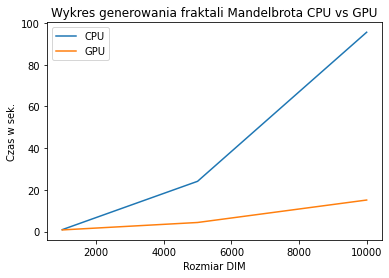

In [2]:
import matplotlib.pyplot as plt

dims = (1000, 5000, 10000)
timeCPU = (0.947622, 24.114844, 95.583010)
timeGPU = (0.811615, 4.371521, 15.140495)


plt.plot(dims, timeCPU, label='CPU')
plt.plot(dims, timeGPU, label='GPU')
plt.xlabel("Rozmiar DIM")
plt.ylabel("Czas w sek.")
plt.title("Wykres generowania fraktali Mandelbrota CPU vs GPU")
plt.legend()
plt.show()